In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class KinematicSteel:

    
    def __init__(self, E, sigma_y, H):
        self.E = E
        self.sigma_y = sigma_y
        self.H = H
        self.alpha = 0

        self.elastic = True
        self.E_t = E
        self.sigma = 0
        self.accumulated_plastic_strain = 0
        self.accumulated_strain = 0



    def increment_strain(self, delta_epsilon):
        # step 1
        delta_s = self.E * delta_epsilon
        s = self.sigma + delta_s
        self.alpha = self.H * self.accumulated_plastic_strain
        self.accumulated_strain = self.accumulated_strain + delta_epsilon

        # step 2
        if self.elastic:
            if (np.abs(s - self.alpha) <= self.sigma_y): # remains elastic
                self.sigma = s
                return
            else: # becomes plastic
                self.elastic = False
                self.E_t = self.E*self.H / (self.E + self.H)
                beta = (self.sigma_y - np.abs(self.sigma - self.alpha)) / (np.abs(s) - np.abs(self.sigma - self.alpha))
        else:
            # step 3 - only triggered if yielded
            if (self.sigma*delta_s < 0): # element is unloading or reloading
                self.elastic = True
                self.E_t = self.E
                self.sigma = s
                return
            else: # element is yielded and continues to yield
                beta = 0
                
        # step 4
        # self.accumulated_strain =+ delta_epsilon
        self.sigma = self.sigma + beta*delta_s + ((self.E * self.H)/(self.E + self.H))*(1 - beta)*delta_epsilon
        self.accumulated_plastic_strain = self.accumulated_plastic_strain + ((1 - beta)/(1 + (self.H/self.E)))*delta_epsilon


In [4]:
YIELD_STRENGTH = 435e6
YOUNGS_MODULUS = 2e11
TANGENT_STIFFNESS = 0.05*YOUNGS_MODULUS
STRAIN_HARDENING_H = TANGENT_STIFFNESS * YOUNGS_MODULUS/(YOUNGS_MODULUS - TANGENT_STIFFNESS)
yield_strain = YIELD_STRENGTH / YOUNGS_MODULUS

num_increments_to_yield = 100
strain_increment = yield_strain/num_increments_to_yield


In [5]:
stress = []
strain = []
plastic_strain = []
modulus = []
yield_stress = []
tangent_modulus = []
steel = KinematicSteel(YOUNGS_MODULUS, YIELD_STRENGTH, STRAIN_HARDENING_H)

num_loading_increments = 2*num_increments_to_yield
num_unloading_increments = 4*num_increments_to_yield
num_reloading_increments = 4*num_increments_to_yield

i = 0
while (i < num_loading_increments):
    steel.increment_strain(strain_increment)
    stress.append(steel.sigma*1e-6)
    strain.append(steel.accumulated_strain)
    plastic_strain.append(steel.accumulated_plastic_strain)
    yield_stress.append(steel.sigma_y*1e-6)
    tangent_modulus.append(steel.E_t*1e-6)
    i += 1

i = 0
while (i < num_unloading_increments):
    steel.increment_strain(-strain_increment)
    stress.append(steel.sigma*1e-6)
    strain.append(steel.accumulated_strain)
    plastic_strain.append(steel.accumulated_plastic_strain)
    yield_stress.append(steel.sigma_y*1e-6)
    tangent_modulus.append(steel.E_t*1e-6)
    i += 1

i = 0
while (i < num_reloading_increments):
    steel.increment_strain(strain_increment)
    stress.append(steel.sigma*1e-6)
    strain.append(steel.accumulated_strain)
    plastic_strain.append(steel.accumulated_plastic_strain)
    yield_stress.append(steel.sigma_y*1e-6)
    tangent_modulus.append(steel.E_t*1e-6)
    i += 1

Text(1112.1661877394636, 0.5, 'stress (MPa)')

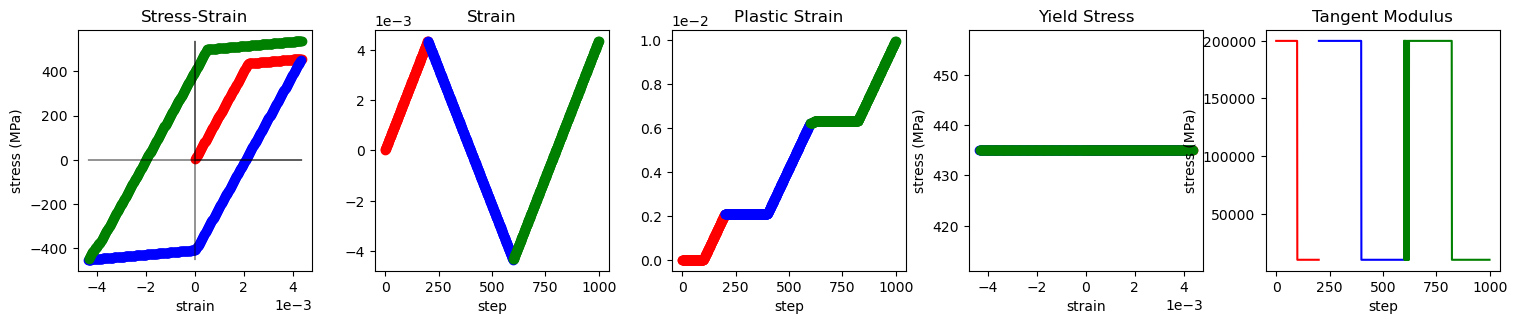

In [6]:
figs, axs = plt.subplots(1, 5)
figs.set_size_inches(15, 3)

axs = axs.flatten()
figs.tight_layout()
# stress-strain
axs[0].set_title("Stress-Strain")
axs[0].scatter(strain[0:num_loading_increments], stress[0:num_loading_increments], c="r")
axs[0].scatter(strain[num_loading_increments:num_loading_increments + num_unloading_increments], stress[num_loading_increments:num_loading_increments + num_unloading_increments], c="b")
axs[0].scatter(strain[num_loading_increments + num_unloading_increments: num_loading_increments + num_unloading_increments + num_reloading_increments], stress[num_loading_increments + num_unloading_increments: num_loading_increments + num_unloading_increments + num_reloading_increments], c="g")
axs[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axs[0].set_xlabel("strain")
axs[0].set_ylabel("stress (MPa)")

axs[0].plot(np.zeros(len(stress)), stress, "-k", linewidth=0.3)
axs[0].plot(strain, np.zeros(len(stress)), "-k", linewidth=0.3)

# strain
axs[1].set_title("Strain")
axs[1].scatter(range(num_loading_increments), strain[0:num_loading_increments], c="r")
axs[1].scatter(range(num_loading_increments, num_unloading_increments + num_loading_increments), strain[num_loading_increments:num_loading_increments + num_unloading_increments], c="b")
axs[1].scatter(range(num_unloading_increments + num_loading_increments, num_unloading_increments + num_loading_increments + num_reloading_increments), strain[num_loading_increments + num_unloading_increments: num_loading_increments + num_unloading_increments + num_reloading_increments], c="g")
axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[1].set_xlabel("step")

# plastic strain
axs[2].set_title("Plastic Strain")
axs[2].scatter(range(num_loading_increments), plastic_strain[0:num_loading_increments], c="r")
axs[2].scatter(range(num_loading_increments, num_unloading_increments + num_loading_increments), plastic_strain[num_loading_increments:num_loading_increments + num_unloading_increments], c="b")
axs[2].scatter(range(num_unloading_increments + num_loading_increments, num_unloading_increments + num_loading_increments + num_reloading_increments), plastic_strain[num_loading_increments + num_unloading_increments: num_loading_increments + num_unloading_increments + num_reloading_increments], c="g")
axs[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[2].set_xlabel("step")

# yield stress
axs[3].set_title("Yield Stress")
axs[3].scatter(strain[0:num_loading_increments], yield_stress[0:num_loading_increments], c="r")
axs[3].scatter(strain[num_loading_increments:num_loading_increments + num_unloading_increments], yield_stress[num_loading_increments:num_loading_increments + num_unloading_increments], c="b")
axs[3].scatter(strain[num_loading_increments + num_unloading_increments: num_loading_increments + num_unloading_increments + num_reloading_increments], yield_stress[num_loading_increments + num_unloading_increments: num_loading_increments + num_unloading_increments + num_reloading_increments], c="g")
axs[3].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axs[3].set_xlabel("strain")
axs[3].set_ylabel("stress (MPa)")

# yield stress
axs[4].set_title("Tangent Modulus")
axs[4].plot(range(num_loading_increments), tangent_modulus[0:num_loading_increments], c="r")
axs[4].plot(range(num_loading_increments, num_unloading_increments + num_loading_increments), tangent_modulus[num_loading_increments: num_unloading_increments + num_loading_increments], c="b")
axs[4].plot(range(num_unloading_increments + num_loading_increments, num_unloading_increments + num_loading_increments + num_reloading_increments), tangent_modulus[num_loading_increments + num_unloading_increments: num_loading_increments + num_unloading_increments + num_reloading_increments], c="g")
axs[4].set_xlabel("step")
axs[4].set_ylabel("stress (MPa)")
# 

In [ ]:
np.max(yield_stress)